In [12]:
#data preprocessing
import pandas as pd
#math operations
import numpy as np
#machine learning
from catboost import CatBoostRegressor, Pool
#data scaling
from sklearn.preprocessing import StandardScaler
#hyperparameter optimization
from sklearn.model_selection import GridSearchCV
#support vector machine model
from sklearn.svm import NuSVR, SVR
#kernel ridge model
from sklearn.kernel_ridge import KernelRidge
#data visualization
import matplotlib.pyplot as plt

from sklearn.metrics import mean_absolute_error
import seaborn as sns

In [6]:
# Step 1 - Feature Engineering and signifiance of these statistical features
import scipy.stats as stats

def gen_features(X):
    strain = []
    strain.append(X.mean())
    strain.append(X.std())
    strain.append(X.min())
    strain.append(X.max())
    strain.append(X.kurtosis())
    strain.append(X.skew())    
    strain.append(np.quantile(X,0.01))
    strain.append(np.quantile(X,0.05))
    strain.append(np.quantile(X,0.95))
    strain.append(np.quantile(X,0.99))
    strain.append(np.abs(X).max())
    strain.append(np.abs(X).mean())
    strain.append(np.abs(X).std())
    #mystuff
    strain.append(np.var(X))
    strain.append(stats.sem(X))
    strain.append(stats.variation(X))
    return pd.Series(strain)

In [8]:
#Create features DF
train = pd.read_csv('train.csv', iterator=True, chunksize=150_000, dtype={'acoustic_data': np.int16, 'time_to_failure': np.float64})

features_X = pd.DataFrame()
times_y = pd.Series()
for df in train:
    ch = gen_features(df['acoustic_data'])
    features_X =features_X.append(ch, ignore_index=True)
    times_y =times_y.append(pd.Series(df['time_to_failure'].values[-1]))

In [9]:
#Split data to training and test
from sklearn.model_selection import train_test_split
train_X, test_X, train_y, test_y = train_test_split(features_X,  times_y, test_size=0.10, random_state=72)

In [10]:
#Model #1 - Catboost

train_pool = Pool(train_X, train_y)
cat_model = CatBoostRegressor(iterations=10000, loss_function='MAE', boosting_type='Ordered')
cat_model.fit(train_X, train_y, silent=True)

cat_test_predictions = cat_model.predict(test_X)
cat_train_predictions = cat_model.predict(train_X)

score = mean_absolute_error(test_y, cat_test_predictions)
print("Cat Boost MAE on Test: " + str(score))

score = mean_absolute_error(train_y, cat_train_predictions)
print("Cat Boost MAE on Train: " + str(score))

Cat Boost MAE on Test: 2.127640998824054
Cat Boost MAE on Train: 1.7455322367765607


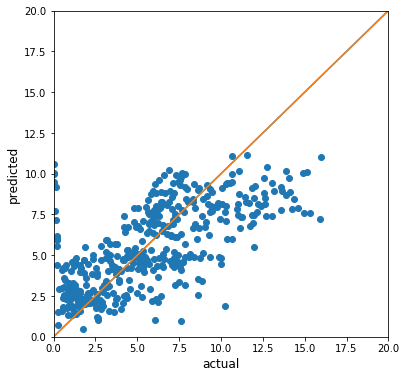

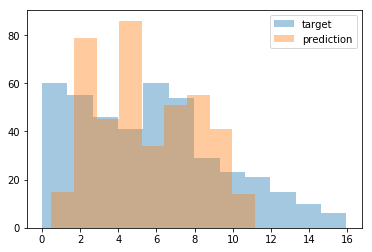

In [82]:
# Predictions vs actual values
plt.figure(figsize=(6, 6))
plt.scatter(test_y, cat_test_predictions)
plt.xlim(0, 20)
plt.ylim(0, 20)
plt.xlabel('actual', fontsize=12)
plt.ylabel('predicted', fontsize=12)
plt.plot([(0, 0), (20, 20)], [(0, 0), (20, 20)])
plt.show()

sns.set_color_codes()
# Hist plot
sns.distplot(test_y, kde=False, label='target');
sns.distplot(cat_test_predictions, kde=False, label='prediction');
plt.legend();

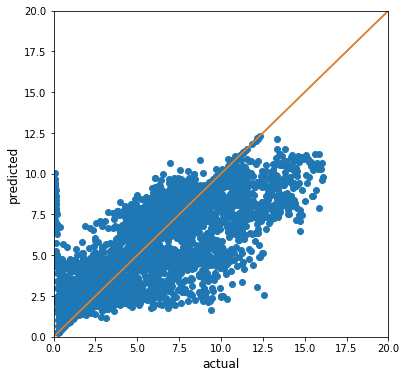

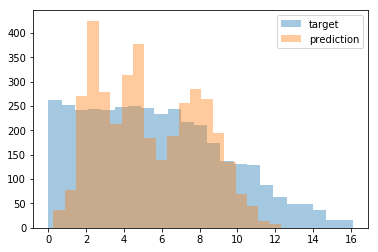

In [15]:
# Predictions vs actual values
plt.figure(figsize=(6, 6))
plt.scatter(train_y, cat_train_predictions)
plt.xlim(0, 20)
plt.ylim(0, 20)
plt.xlabel('actual', fontsize=12)
plt.ylabel('predicted', fontsize=12)
plt.plot([(0, 0), (20, 20)], [(0, 0), (20, 20)])
plt.show()


# Hist plot
sns.distplot(train_y, kde=False, label='target');
sns.distplot(cat_train_predictions, kde=False, label='prediction');
plt.legend();

In [16]:
#Model #2 - Support Vector Machine w/ RBF + Grid Search

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.svm import NuSVR, SVR


scaler = StandardScaler()
scaler.fit(train_X)
X_train_scaled = scaler.transform(train_X)

parameters = [{'gamma': [0.001, 0.005, 0.01, 0.02, 0.05, 0.1],
               'C': [0.1, 0.2, 0.25, 0.5, 1, 1.5, 2]}]
               #'nu': [0.75, 0.8, 0.85, 0.9, 0.95, 0.97]}]

SVM_model = GridSearchCV(SVR(kernel='rbf', tol=0.01), parameters, cv=5, scoring='neg_mean_absolute_error')
SVM_model.fit(X_train_scaled, train_y.values.flatten())

X_test_scaled = scaler.transform(test_X)

SVM_predictions = SVM_model.predict(X_test_scaled)
SVM_train_predictions = SVM_model.predict(X_train_scaled)

score = mean_absolute_error(test_y, SVM_predictions)
print("SVM model Test MAE: " + str(score))

score = mean_absolute_error(train_y, SVM_train_predictions)
print("SVM model Train MAE: " + str(score))

SVM model Test MAE: 2.117549823760987
SVM model Train MAE: 2.033954637974877


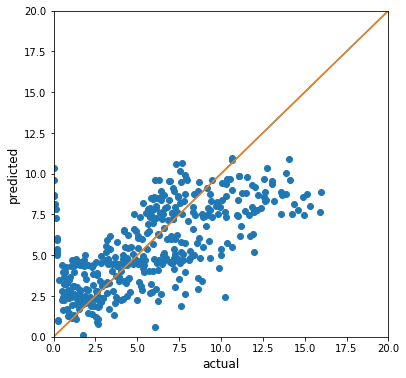

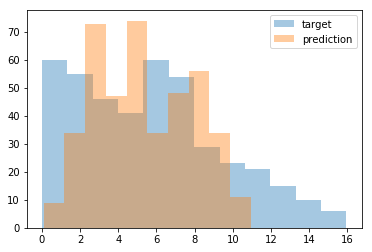

In [80]:
# Predictions vs actual values
plt.figure(figsize=(6, 6))
plt.scatter(test_y, SVM_predictions)
plt.xlim(0, 20)
plt.ylim(0, 20)
plt.xlabel('actual', fontsize=12)
plt.ylabel('predicted', fontsize=12)
plt.plot([(0, 0), (20, 20)], [(0, 0), (20, 20)])
plt.show()

sns.set_color_codes()
# Hist plot
sns.distplot(test_y, kde=False, label='target');
sns.distplot(SVM_predictions, kde=False, label='prediction');
plt.legend();

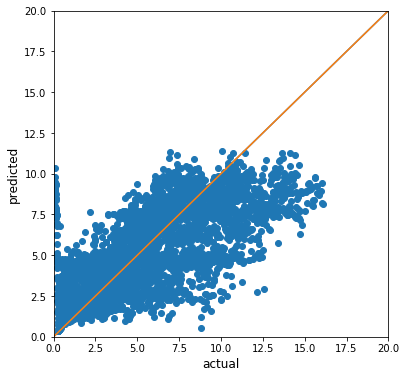

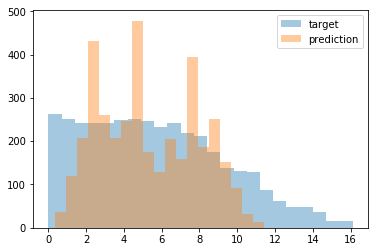

In [18]:
# Predictions vs actual values
plt.figure(figsize=(6, 6))
plt.scatter(train_y, SVM_train_predictions)
plt.xlim(0, 20)
plt.ylim(0, 20)
plt.xlabel('actual', fontsize=12)
plt.ylabel('predicted', fontsize=12)
plt.plot([(0, 0), (20, 20)], [(0, 0), (20, 20)])
plt.show()


# Hist plot
sns.distplot(train_y, kde=False, label='target');
sns.distplot(SVM_train_predictions, kde=False, label='prediction');
plt.legend();

In [317]:
#Model 3 Random Forest Regressor

from sklearn.ensemble import RandomForestRegressor

test_score = 10
rounds = 1

RF_Model = RandomForestRegressor(n_estimators=75, min_samples_split = 2, min_samples_leaf=1, max_features= None, 
                                     bootstrap = True, n_jobs=-1, oob_score=False)
while(test_score > 2.17 and rounds <= 31):
    RF_Model.fit(train_X,train_y)

    RF_predictions = RF_Model.predict(test_X)

    test_score = mean_absolute_error(test_y, RF_predictions)
    
    print("Round: " + str(rounds) + " Score: " + str(test_score))
    rounds += 1

print("RF model Test MAE: " + str(test_score))

RF_train_predictions = RF_Model.predict(train_X)

score = mean_absolute_error(train_y, RF_train_predictions)

print("RF model Train MAE: " + str(score))

Round: 1 Score: 2.1792827938098367
Round: 2 Score: 2.207777879181162
Round: 3 Score: 2.2141121972061883
Round: 4 Score: 2.194395947544477
Round: 5 Score: 2.222705251796553
Round: 6 Score: 2.2151025939471194
Round: 7 Score: 2.205759420996408
Round: 8 Score: 2.2028827220440648
Round: 9 Score: 2.2112445433958374
Round: 10 Score: 2.1962716412403607
Round: 11 Score: 2.2301776524746737
Round: 12 Score: 2.214481207062887
Round: 13 Score: 2.2152199934626338
Round: 14 Score: 2.213884035177889
Round: 15 Score: 2.1968652901904466
Round: 16 Score: 2.1675455571017643
RF model Test MAE: 2.1675455571017643
RF model Train MAE: 0.8211819666127437


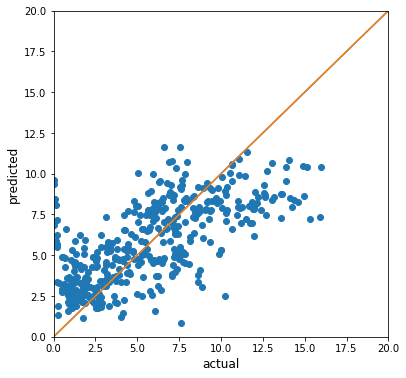

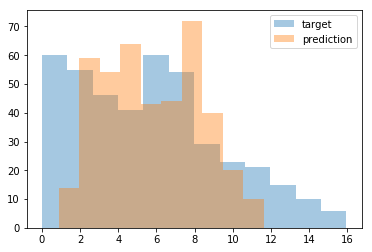

In [309]:
# Predictions vs actual values
plt.figure(figsize=(6, 6))
plt.scatter(test_y, RF_predictions)
plt.xlim(0, 20)
plt.ylim(0, 20)
plt.xlabel('actual', fontsize=12)
plt.ylabel('predicted', fontsize=12)
plt.plot([(0, 0), (20, 20)], [(0, 0), (20, 20)])
plt.show()

sns.set_color_codes()
# Hist plot
sns.distplot(test_y,  kde=False, label='target');
sns.distplot(RF_predictions, kde=False, label='prediction');
plt.legend();

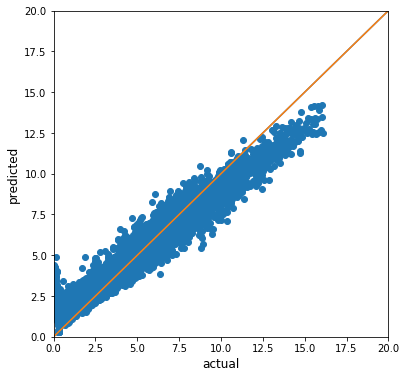

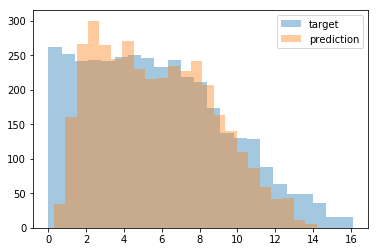

In [310]:
# Predictions vs actual values
plt.figure(figsize=(6, 6))
plt.scatter(train_y, RF_train_predictions)
plt.xlim(0, 20)
plt.ylim(0, 20)
plt.xlabel('actual', fontsize=12)
plt.ylabel('predicted', fontsize=12)
plt.plot([(0, 0), (20, 20)], [(0, 0), (20, 20)])
plt.show()


# Hist plot
sns.distplot(train_y, kde=False, label='target');
sns.distplot(RF_train_predictions, kde=False, label='prediction');
plt.legend();

In [311]:
#Save Kaggle Predictions all at once
import glob

file_names = sorted(list(glob.glob("./test/*.csv")))

output = ["seg_id,time_to_failure\n","seg_id,time_to_failure\n","seg_id,time_to_failure\n"]

for file_name in file_names:
    test = pd.read_csv(file_name, dtype={'acoustic_data': np.int16})
    ch = gen_features(test['acoustic_data'])
    X_test = pd.DataFrame(ch).transpose()
    
    #Cat Prediction
    prediction = cat_model.predict(X_test)
    output[0] += file_name.split(".")[1][6:] + "," + str(prediction[0]) + "\n"
    
    #SVM Prediction
    X_test_scaled = scaler.transform(X_test)
    prediction = SVM_model.predict(X_test_scaled)
    output[1] += file_name.split(".")[1][6:] + "," + str(prediction[0]) + "\n"
    
    #Random Forest Prediction
    prediction = RF_Model.predict(X_test)
    output[2] += file_name.split(".")[1][6:] + "," + str(prediction[0]) + "\n"

output_file = open("test_results_Cat_Model.csv", "w+")
output_file.write(output[0])
output_file.close()

output_file = open("test_results_SVM_Model.csv", "w+")
output_file.write(output[1])
output_file.close()

output_file = open("test_results_RF_Model.csv", "w+")
output_file.write(output[2])
output_file.close()

In [166]:
#Test Combining models

#cat_test_predictions,cat_train_predictions 
#SVM_predictions,SVM_train_predictions
#RF_predictions,RF_train_predictions

mean_predictions = np.empty(0)
for i in range(len(RF_predictions)):
    mean_predictions = np.append(mean_predictions, (RF_predictions[i] + SVM_predictions[i] + cat_test_predictions[i])/3)

score = mean_absolute_error(test_y, mean_predictions)
print("Average Model Test MAE: " + str(score))

normalized_predictions = np.empty(0)
for i in range(len(RF_predictions)):
    normalized_predictions = np.append(normalized_predictions, (cat_test_predictions[i]*.45 + SVM_predictions[i]*.4 + RF_predictions[i]*.15))

score = mean_absolute_error(test_y, normalized_predictions)
print("Normalized Model Test MAE: " + str(score))

weighted_normalized_predictions = np.empty(0)
for i in range(len(RF_predictions)):
    weighted_normalized_predictions = np.append(weighted_normalized_predictions, normalized_predictions[i]*.75 + mean_predictions[i]*.25)

score = mean_absolute_error(test_y, weighted_normalized_predictions)
print("Weighted Normalized Model Test MAE: " + str(score))



Average Model Test MAE: 2.111059109864449
Normalized Model Test MAE: 2.1063458390576018
Weighted Normalized Model Test MAE: 2.1056298586771005


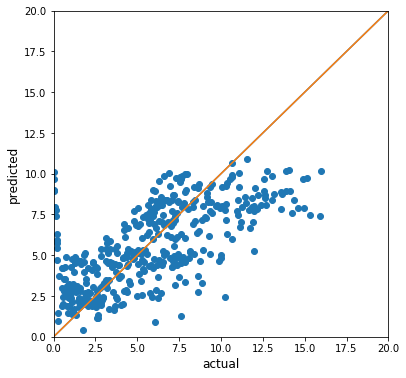

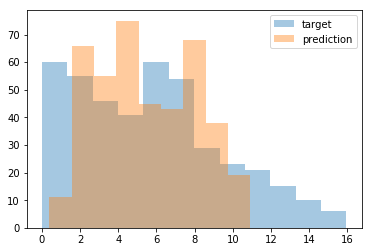

In [167]:
# Predictions vs actual values
plt.figure(figsize=(6, 6))
plt.scatter(test_y, weighted_normalized_predictions)
plt.xlim(0, 20)
plt.ylim(0, 20)
plt.xlabel('actual', fontsize=12)
plt.ylabel('predicted', fontsize=12)
plt.plot([(0, 0), (20, 20)], [(0, 0), (20, 20)])
plt.show()

sns.set_color_codes()
# Hist plot
sns.distplot(test_y,  kde=False, label='target');
sns.distplot(weighted_normalized_predictions, kde=False, label='prediction');
plt.legend();

In [135]:
file_names = sorted(list(glob.glob("./test/*.csv")))

output = "seg_id,time_to_failure\n"

for file_name in file_names:
    test = pd.read_csv(file_name, dtype={'acoustic_data': np.int16})
    ch = gen_features(test['acoustic_data'])
    X_test = pd.DataFrame(ch).transpose()
    
    #Cat Prediction
    cat_prediction = cat_model.predict(X_test)
    
    
    #SVM Prediction
    X_test_scaled = scaler.transform(X_test)
    SVM_prediction = SVM_model.predict(X_test_scaled)
    
    #Random Forest Prediction
    RF_prediction = RF_Model.predict(X_test)
    
    mean_prediction = (RF_prediction + SVM_prediction + cat_prediction)/3
    normalized_prediction = cat_prediction*.45 + SVM_prediction*.4 + RF_prediction*.15
    weighted_normalized_prediction = normalized_prediction*.75 + mean_prediction*.25
    
    #print(weighted_normalized_prediction[0])
    output += file_name.split(".")[1][6:] + "," + str(weighted_normalized_prediction[0]) + "\n"
    
output_file = open("test_results_Feature_Combination.csv", "w+")
output_file.write(output)
output_file.close()

In [155]:
wavenet = pd.read_csv("sample_wavenet_submission_1.91.csv",dtype={'seg_id': np.str, 'time_to_failure': np.float64})
wavenet = wavenet.drop('seg_id', axis = 1)

cat_preds = pd.read_csv("test_results_Cat_Model.csv",dtype={'seg_id': np.str, 'time_to_failure': np.float64})
cat_preds = cat_preds.drop('seg_id', axis = 1)

SVM_preds = pd.read_csv("test_results_SVM_Model.csv",dtype={'seg_id': np.str, 'time_to_failure': np.float64})
SVM_preds = SVM_preds.drop('seg_id', axis = 1)



In [162]:
#Average of WaveNet, CAT, and SVM
count = 0

file_names = sorted(list(glob.glob("./test/*.csv")))

output = "seg_id,time_to_failure\n"

for file_name in file_names:
    mean_prediction = (wavenet.iloc[count] + cat_preds.iloc[count] + SVM_preds.iloc[count])/3
    print(mean_prediction[0])
    
    output += file_name.split(".")[1][6:] + "," + str(mean_prediction[0]) + "\n"
    
    
    count += 1

output_file = open("test_results_Wave_Cat_SVM_Average.csv", "w+")
output_file.write(output)
output_file.close()

4.538241294213493
4.872955152781217
5.033684506352766
8.022893228058537
6.141170443543022
1.8096479053670766
6.976065987698994
3.08143063185094
4.348671074226224
2.705198809573035
2.612140750144964
4.271249067358554
3.5587166867129643
2.8033194752206825
8.004203371374286
3.9148408610309944
6.18214646132783
3.481485455738802
6.56759093715447
4.961449742675079
4.792600793075112
9.072757194356868
3.513284500209085
4.499024306252892
7.486302186654821
5.091625431498336
7.551655520514887
3.9167710585810602
2.297951418756059
5.252608026038286
4.335811630223158
3.6004310769568737
3.692345947002062
6.8459532462114785
1.867765866020978
3.9307265272526006
7.726658021025727
3.4623185313758498
4.627517737491735
2.564183682568471
6.999636415672945
9.579560002244856
7.6764967604369945
4.818592433020769
7.511448253782421
8.117126210188218
7.210941275677757
5.211982153002305
3.7842235469705856
5.148957742509785
4.474984774423511
7.265184803997102
9.81484383151677
2.4090491386844746
3.4231121681107712
7

3.996214668020261
9.817547156190136
6.004012909857663
4.476438048409753
6.842538354711745
3.8896033813478823
9.52042204035846
2.8454184748835663
2.278492677340109
9.417350564852406
5.462793026185797
8.562696339000242
8.865436589390866
1.8809467903493717
4.314606331342046
3.7874880846539125
6.47915079803719
8.335681645921992
9.648605317132594
3.3069738873315413
3.5441223441007454
5.904280819615266
4.19156787562465
9.086113586003883
6.724633119128195
9.383045263218413
2.159547761118421
7.505335975873955
3.856182979587065
4.3628900184356265
3.165267049364091
7.379367659211831
5.125721279000692
3.2013879312942883
2.280312679252865
6.999096911246393
5.067091182972574
7.956793549570441
8.11968642085444
6.573604807720578
6.298333282171374
3.682509321305392
7.081712761507028
4.596723897909605
7.1050743016270275
5.659117755789034
2.8907383438631062
5.074428747943031
10.382880767047679
3.553357595581801
3.942592862742869
3.364916514563536
8.16575479258835
2.615186815894401
6.3609636417876425
5.2

4.812108315804232
9.502255997587852
7.59072350767235
8.772707008435654
3.8309981544932885
6.117771520818998
4.684821871806819
3.726660484397248
7.130809340738188
10.105372342620448
2.6955535294259936
3.889376545294015
9.626155991998298
4.574241339971843
5.09502756361997
4.567756537536525
5.139354146995903
6.496009263118199
6.557078702176114
3.8832876304310404
7.63476150408626
9.291262764067328
4.801132847924982
2.6533888249402446
4.381274715636365
4.690932094751277
1.9250058325691157
2.523197060692695
8.143606820995872
3.3096004250520585
3.4339122936686146
2.4294313345139424
4.247138937629583
2.413360469713607
7.967982428501396
3.8797030399408357
8.319942166103404
5.108297874617777
4.713456310557709
4.124800098622093
9.260060882639705
4.4614652579898175
9.306730310100885
3.331406975279299
5.973159666034635
6.941266364754489
8.167672214418543
8.778487369137878
5.087441561377241
6.260665026076167
9.359100249368824
4.840218834648042
9.242668254729017
4.483152816361778
2.057527492210394
6.

4.849281523514754
2.0218632766964113
8.423152158467522
2.1307229579774343
4.122826416657819
3.8576758244637883
2.9040136148745006
3.245626904305297
4.860054650629811
7.415596579630271
2.21769275090181
5.833513914023405
6.251642560094477
1.9756446955585265
8.314986065211476
9.328683540004496
4.59025874977353
3.4188085765126512
3.8440565391465427
3.6384995165032414
7.605466579266163
5.877677656900153
1.6458356117892183
5.576696801107285
3.4067506620612282
2.0968986103076666
9.95157484447318
2.6121570354994073
10.661579432096284
2.6773305893740478
9.823203686167526
7.366571464211425
1.7202297248866436
3.259809889058586
5.221339576776174
4.229112649113286
9.315008683611312
8.265067670215467
4.6719659897125085
3.382748810952601
7.243325246190881
8.002262361727853
5.048177047006677
4.176673319091305
2.748827516593334
10.105685164677395
6.681639285903192
8.85751464699892
9.358205612213606
10.181022915206936
9.29803621157504
4.272106448920354
6.800369403772255
7.965241095103578
4.7513668141263

In [164]:
#Weighted Average of WaveNet, CAT, and SVM
count = 0

file_names = sorted(list(glob.glob("./test/*.csv")))

output = "seg_id,time_to_failure\n"

for file_name in file_names:
    weighted_prediction = wavenet.iloc[count]*.3 + cat_preds.iloc[count]*.5 + SVM_preds.iloc[count]*.2
    print(mean_prediction[0])
    
    output += file_name.split(".")[1][6:] + "," + str(weighted_prediction[0]) + "\n"
    
    
    count += 1

output_file = open("test_results_Wave_Cat_SVM_Performance.csv", "w+")
output_file.write(output)
output_file.close()

4.553506871712538
4.7969409894832005
4.9330649178192285
7.914301407020711
6.078365735642722
2.0461191539134367
6.996761260695126
2.946128589266356
4.268552805288714
2.695909714133716
2.5510172575675107
4.302443916445157
3.614235780270775
2.8159014112481753
8.026483719520566
4.081269100209537
6.249630068138716
3.6145872065126485
6.625334348698336
4.977035264736422
4.907300691253823
9.31193683117557
3.7042035723725264
4.4842338203515375
7.472466543582043
5.212434675759338
7.526030455289828
4.111464757973495
2.197962522353375
5.195430922319695
4.772783130741262
3.560038380459421
3.772563749737221
6.662712870368399
1.9930758250032676
4.085558346055727
7.671063487598195
3.652537399193021
4.61388180648586
2.52823020374349
6.89749545214173
9.627043378529857
7.818950992024001
4.788451551522705
7.493350694428354
8.234293669832606
7.249076214313945
5.236161627202541
4.117542831037597
5.0316062846008425
4.576867610993039
7.2168098110731576
10.02683466891988
2.4001500799457967
3.368520080841794
7.

2.4620424421486526
5.579844481169349
7.810061359227493
7.171584315636513
3.355547600359223
4.527106719875135
4.490691638757787
10.428188244956155
8.377886164081568
2.6838232651911698
2.2305046051252555
8.015376377552647
3.2667101416598086
4.168886727196097
5.935495767605132
8.238833723988543
7.304475241354684
4.134802758583707
5.170786487541628
4.015102530448963
3.7456851813791503
3.935149307971504
7.785028439932701
7.789581669090848
7.526925658850768
7.2304397728505165
4.446201282464868
3.084423217170438
2.460245667848692
7.119283475866674
2.6617888950329935
3.3845322657968797
10.116758199969233
1.5652128741447633
2.513503578325517
3.9292087834615117
4.826923300006204
6.560262012331071
1.9354580871047324
2.656887375533576
1.9333556957879932
6.162544722353521
4.947529279312653
9.769258753861399
9.965334079051754
4.226063672851967
3.376408981525935
4.300524153327199
8.302585437274491
6.374535318912243
6.46873074159455
6.487070475880326
8.85233320648167
3.3610992377699445
4.5958112053137

6.970890877603402
3.6897853690615143
4.446603150334658
3.216022960886235
1.3519921438870754
4.471911169329728
4.899411934024999
3.809619662528207
2.6709437554525026
4.5576215231077475
2.475302828263357
2.2344693548461203
4.3998597798898285
5.201897922926903
6.668825080825949
2.270675268002376
5.033517975936462
8.681725054247295
8.748635775450557
9.15458308515099
3.542963674134512
3.2381294526781454
8.723931369675633
6.7226746028466025
1.1008640424762017
4.890777692289831
5.098579110327166
3.9475252383726573
7.978010151436485
4.070804017349861
2.01505268880904
7.704096451604849
2.852982569402993
2.4855776572804147
2.830823410866487
4.574955527713213
4.05756791785562
4.468186449852022
4.970314830854874
6.891955643608851
6.744085114493279
4.428969145307048
5.222886963612735
5.214547728281538
2.657676815716093
2.920039226511863
7.557592939216209
6.6934390508216515
9.346793602157529
2.4448419761220688
4.28768492243835
3.4391177566509685
1.1195005056902998
9.21824756778548
6.340493228005715


4.00362787254514
7.58087837081522
3.1224750830434638
1.8248405448186786
4.542044399338604
1.4777531297046687
9.077115048160518
7.103558110991515
2.7857541346961683
8.43603844066315
7.799407156740888
1.8114330649833934
4.827751012576945
1.9103721735529042
8.356461079259264
2.0966668780610362
4.3374583546795815
3.991803641699258
2.931320282789123
3.3468359587626693
4.9343250299210455
7.417612120422102
2.148194015300992
5.974424008994337
6.3057113202997455
1.9191029995106825
8.37706916475886
9.543825573280593
4.6205950643706
3.4740996321953883
3.8699989248670517
3.7991874563036996
7.613938723942661
5.774183262655669
1.6455982323339757
5.738797704700502
3.4796441030841123
2.05681834034115
10.293075607933801
2.5696217592209267
10.529179227479936
2.607775544176857
9.92510928057177
7.277302559041803
1.727687538423362
3.321089928753333
5.294893358757845
4.534700573508234
9.315907197597904
8.296424235458751
4.683447602611309
3.5382084246515535
7.21086170904662
8.105831537230383
5.14890926700135

3.9835727127100036
9.696026554114015
6.019302434143371
8.908271941621344
4.933078524688332
7.403193125699283
5.10932682665612
3.71409082714335
3.1040770368381287
7.289962670215743
3.656639796701862
4.272025711615205
8.694921974126839
5.147642115003354
7.9398402476151695
2.342394695989543
4.466534665857862
1.5160028834949708
2.048611079733618
9.777682784082874
4.87303589413528
5.378250510703468
10.035796678692805
5.035827073540229
4.891714651582445
6.952499535209499
4.144528998612941
3.4930504987213347
4.355475557532515
3.05162276544005
4.855321101676348
6.287906739490585
3.1109775039261036
4.233691629877756
2.9426370590813393
6.896415202304068
8.225344818855374
5.506373516151292
8.53463402686476
6.811762935924671
7.855005863705307
4.0834449407277145
8.219614459267024
4.673431291038027
4.741608441919676
5.849153273358304
4.465737523398297
1.4583935614234949
9.951645912116511


In [165]:
#Average of Weighted Average + Average from WaveNet, CAT, and SVM
count = 0

file_names = sorted(list(glob.glob("./test/*.csv")))

output = "seg_id,time_to_failure\n"

for file_name in file_names:
    mean_prediction = (wavenet.iloc[count] + cat_preds.iloc[count] + SVM_preds.iloc[count])/3
    weighted_prediction = wavenet.iloc[count]*.3 + cat_preds.iloc[count]*.5 + SVM_preds.iloc[count]*.2
    
    final_prediction = (mean_prediction + weighted_prediction)/2
    print(final_prediction[0])
    output += file_name.split(".")[1][6:] + "," + str(final_prediction[0]) + "\n"
    
    
    count += 1

output_file = open("test_results_Wave_Cat_SVM_Final_Average.csv", "w+")
output_file.write(output)
output_file.close()

4.5458740829630155
4.834948071132208
4.983374712085997
7.968597317539624
6.109768089592872
1.9278835296402566
6.98641362419706
3.013779610558648
4.308611939757469
2.7005542618533758
2.5815790038562376
4.286846491901856
3.5864762334918696
2.809610443234429
8.015343545447426
3.9980549806202657
6.215888264733273
3.5480363311257253
6.596462642926403
4.96924250370575
4.849950742164468
9.19234701276622
3.6087440362908056
4.491629063302215
7.479384365118432
5.152030053628837
7.538842987902358
4.014117908277278
2.247956970554717
5.2240194741789905
4.554297380482209
3.580234728708147
3.732454848369642
6.754333058289939
1.9304208455121228
4.008142436654164
7.698860754311961
3.557427965284435
4.620699771988798
2.5462069431559806
6.948565933907338
9.603301690387356
7.747723876230498
4.803521992271737
7.502399474105388
8.175709940010412
7.230008744995851
5.224071890102422
3.9508831890040916
5.0902820135553135
4.525926192708275
7.24099730753513
9.920839250218325
2.4045996093151354
3.3958161244762826

6.969933613531424
8.268924141892766
4.2442834898338475
2.612471628867082
9.148163283734174
8.918481221718988
2.859126480186597
3.456613958095093
8.713254695372225
9.441315101758999
5.806554020834255
7.1865065150912155
2.4207451508988904
1.5335795043931575
8.634664132228709
3.7384454092785715
1.858840663383645
8.065232357004568
7.406399097534955
3.562497093582558
4.125032979704983
7.547072343489077
6.157773692800909
9.433581168451848
3.4748649221814665
3.1046268897691665
6.8823128197688055
8.295690931632251
4.066890201472913
3.4008389149863674
8.298148034006836
11.220228546793043
3.7001005451018165
2.7901260525689104
3.1781293987904427
5.992868355713523
8.285630736129221
3.011616205578661
7.677270289620747
4.290276762378746
4.995291011617729
3.9684639285354946
4.115631166381453
6.749997872105157
3.1712382364911824
7.113323473889235
4.106919763352578
9.850911386419028
6.026517424863862
4.571350445789054
6.909866596541475
3.9517970470423394
9.458427831819357
2.837844300770355
2.2516559119

6.041215555349577
4.323191277571954
3.1127647193171155
4.308472174767448
4.43683312957471
1.594054753163178
3.440111845164367
7.555173237102519
5.4707607931348985
4.572090422006175
9.986060569161424
8.793922245442436
2.591794883889494
9.05302895188619
3.8001013000604504
8.88789265751828
3.0349059586406097
6.489505586418699
4.407571760506181
2.748955795935853
7.922376155489687
4.855251063314029
4.532841844366209
3.7824439852803584
1.7420686234681164
9.905972403248377
4.078690794636188
6.966772265035667
3.492687820060408
4.157813409512746
2.1966909885859787
6.113985093553958
0.6892356454790574
3.6445892462242773
6.737819596145364
6.41771547865816
8.410040937939204
3.894868805468211
8.053721708501637
2.2712836445078337
6.832708593825608
6.37309618784579
3.1331487105317377
3.1971413242490234
5.931033522805347
4.670932970237489
5.276037903464846
4.571401754042315
4.47429813121496
3.3817239592046264
1.573826627141361
7.754280489963381
9.600604033880316
3.069393043764485
8.87682591994405
5.94

4.583174803910534
5.541736495198078
5.482758706425193
6.988156252620691
3.185234184408605
6.362950710775857
9.923611899663026
7.4991077486569475
6.3145968349101915
1.741465621188183
4.63253570258007
3.1462274799541055
1.9740859576734469
3.782182600678339
5.3240676016048765
3.6223057149607247
3.319902022299633
4.2171297505781675
5.116257705975329
4.587907370311175
8.557592451141915
5.728708015806442
7.011991387696423
2.707195730475567
5.274966065322495
6.88591122558204
6.9135765500245245
2.087934974300822
9.063222243545312
7.588807539118174
4.726473538379857
3.763811276431749
4.906786980884462
3.8134667597446965
1.2389029622822183
6.854064326831765
7.884277522341478
4.036310526751111
4.156501886818916
4.156419644522279
2.7802712679597175
9.010090370220528
2.672256993685637
3.894835663284508
6.821357007680818
3.1905872442690137
2.8580478648711303
1.994620838835535
6.111307804060097
4.758473071916619
0.7967173764483837
6.796110336322085
2.5404416260201232
9.845194249948868
8.7983447083830

9.612266455146607
4.968764665622425
4.764881248325226
8.155309138342275
9.76482681473125
7.811901367744081
3.4271990286885528
6.173854097647466
4.289121883103791
4.058490613871342
7.600776781589225
1.1114997355281515
9.222350047579855
7.847055557155427
6.141070675516831
3.5714370290113866
4.167967948038992
6.865449326778765
4.194193553149498
6.898538381760325
3.914954973758085
5.926729699775434
5.050786257189644
6.714108558150386
8.662672485314715
3.0682526205582867
4.53370882304022
8.291821809912914
3.6761243399248897
6.855202184923853
4.440195133747646
3.931226796097447
8.82945726377018
2.17308862965955
4.426064483746093
8.825196360445604
3.9298061898692183
5.002034329706776
5.484779269656036
5.481704049057917
2.7933879440974794
4.451424667778951
7.278690056013085
3.4083019695250796
2.3343180080228825
3.3663349821314608
4.520485022490146
4.15491592841756
4.253128672135945
3.9565291548210713
3.9972515766981083
3.4806764888366652
9.23659537334669
7.818210976176001
6.866558048134699
4.4

In [224]:
#Load kaggle submissions

ensemble = pd.read_csv("test_results_Wave_Cat_SVM_Performance.csv",dtype={'seg_id': np.str, 'time_to_failure': np.float64})

wavenet = pd.read_csv("sample_wavenet_submission_1.91.csv",dtype={'seg_id': np.str, 'time_to_failure': np.float64})

Cat_Data = pd.read_csv("test_results_Cat_Model.csv",dtype={'seg_id': np.str, 'time_to_failure': np.float64})

SVM_Data = pd.read_csv("test_results_SVM_Model.csv",dtype={'seg_id': np.str, 'time_to_failure': np.float64})

segment_nums = []
for i in range(len(ensemble)):
    segment_nums.append(i)

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "
No handles with labels found to put in legend.


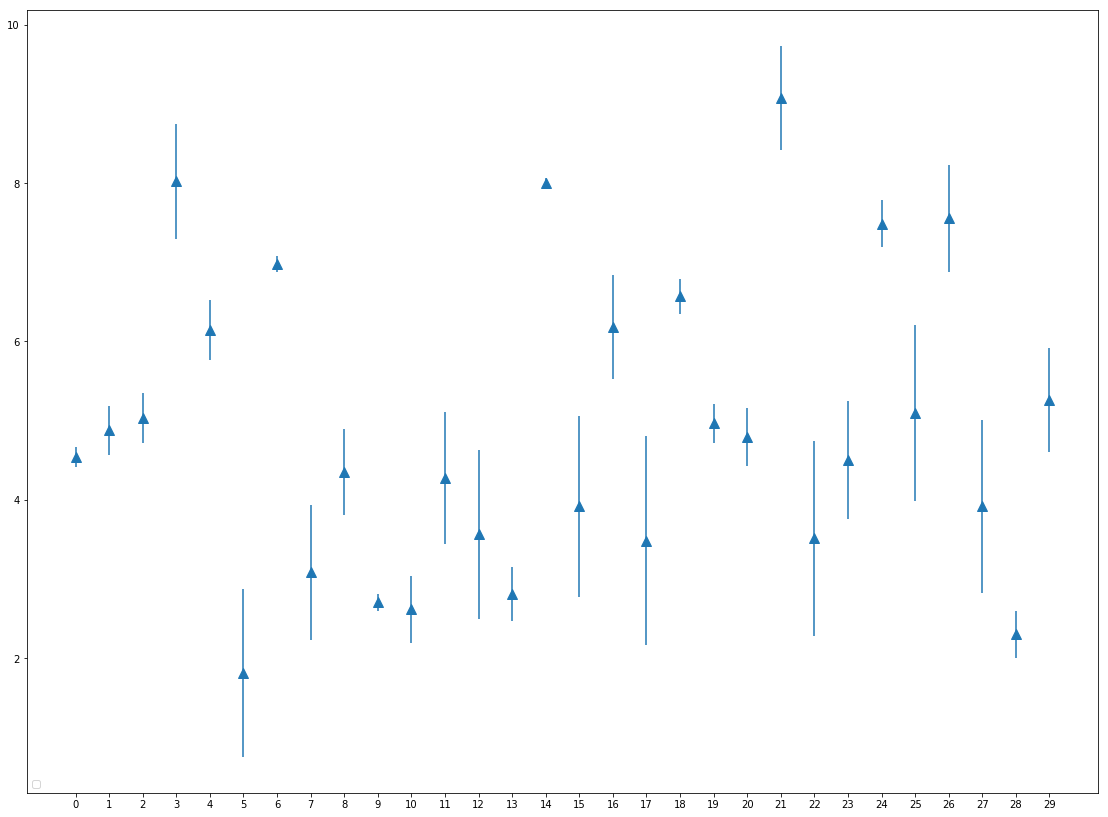

In [315]:
x = range(100)
y = range(100,200)
plot_amount = 30

fig = plt.figure(figsize = [6.4*3, 4.8*3])
#plt.grid(axis = 'both')
plt.xticks(np.arange(plot_amount))
ax1 = fig.add_subplot(111)


#ax1.scatter(segment_nums[:plot_amount], ensemble['time_to_failure'][:plot_amount], s=100, marker="s", label='ensemble')
#ax1.scatter(segment_nums[:plot_amount], wavenet['time_to_failure'][:plot_amount], s=100, marker="o", label='CNN (dilated)')
#ax1.scatter(segment_nums[:plot_amount], Cat_Data['time_to_failure'][:plot_amount], s=100,  marker="o", label='Cat')
#ax1.scatter(segment_nums[:plot_amount], SVM_Data['time_to_failure'][:plot_amount], s=100,  marker="o", label='SVM')

x = np.arange(plot_amount)
y = np.empty(0)
e = np.empty(0)

for i in range(plot_amount):
    y = np.append(y, np.array([wavenet['time_to_failure'][i],Cat_Data['time_to_failure'][i],SVM_Data['time_to_failure'][i]]).mean())
    e = np.append(e, np.array([wavenet['time_to_failure'][i],Cat_Data['time_to_failure'][i],SVM_Data['time_to_failure'][i]]).std())

#print(e)
plt.errorbar(x, y, e, linestyle='None', marker='^',markersize = "10")

plt.legend(loc='lower left');
plt.show()